In [2]:
#import the necessary dependencies
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from glob import glob

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocessing
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing

In [4]:
#for kaggle notebook
data_dir = '/kaggle/input/cricket-shot-dataset/data'

In [5]:
#lists the folders present in the given path
class_names = os.listdir(data_dir)
class_names

['pullshot', 'sweep', 'drive', 'legglance-flick']

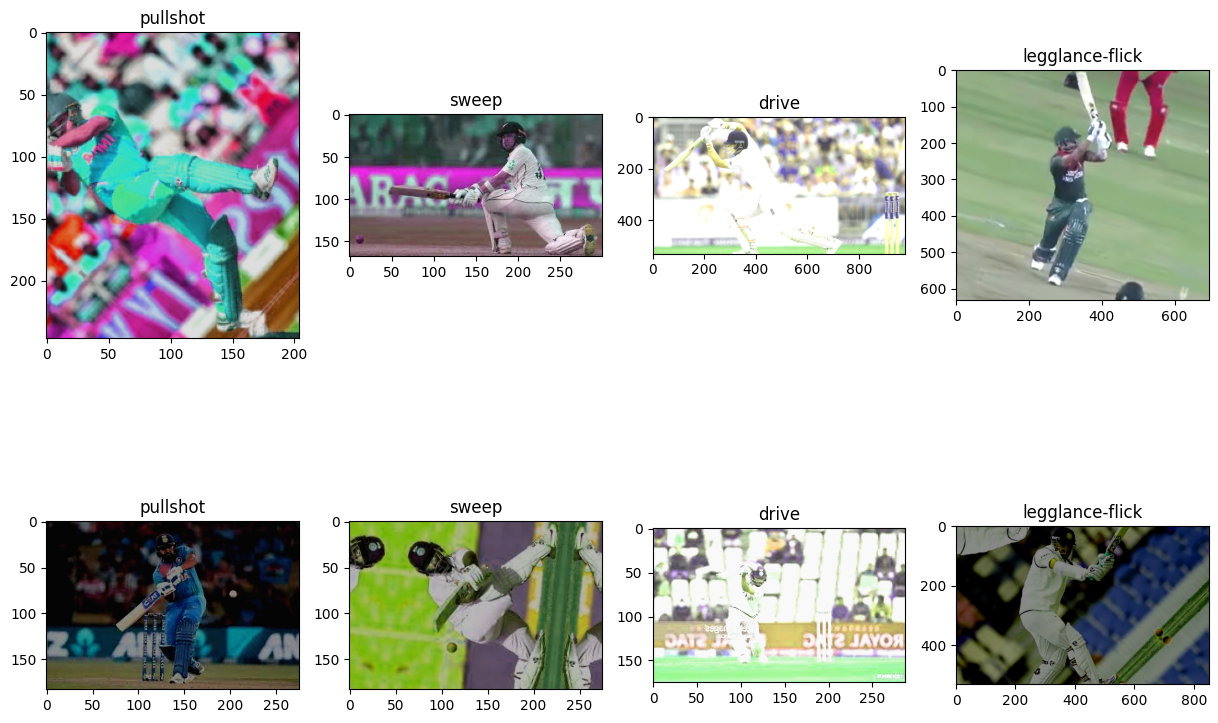

In [7]:
def visualize_images(image_paths: List[str]):
        max_rows = 2
        max_cols = 4
        # Create a figure and a set of subplots
        fig, axs = plt.subplots(max_rows, max_cols, figsize=(15,10))
        idx = 0
        for col in range(max_cols):
            for row in range(max_rows):
                img = cv2.imread(image_paths[idx])
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                class_name = image_paths[idx].split('/')[-2]
                axs[row, col].imshow(image, )
                axs[row, col].set_title(class_name)
                idx += 1
        plt.show()
        
image_paths = []
for class_name in class_names:
    paths = random.sample(glob(os.path.join(data_dir, class_name)+'/'+"*.png"), k=2)
    image_paths.extend(paths)
visualize_images(image_paths)

In [6]:
#creating a dataframe with image paths and labels
image_paths = []
class_labels = []
for class_name in class_names:
    paths = glob(os.path.join(data_dir, class_name) + '/' + "*.png")
    image_paths.extend(paths)
    class_labels.extend([class_name]*len(paths))
df = pd.DataFrame(data={'image_path': image_paths, 'label': class_labels})

In [7]:
print(df['label'].value_counts())

label
pullshot           1228
drive              1173
sweep              1100
legglance-flick    1085
Name: count, dtype: int64


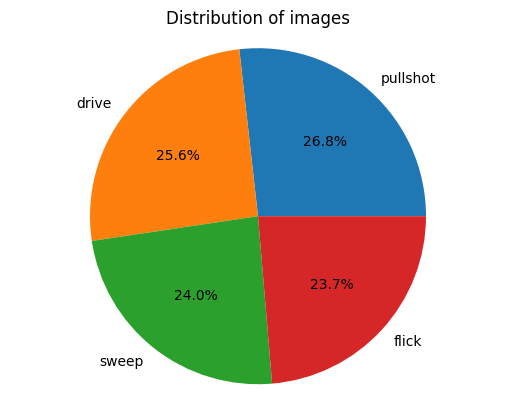

In [13]:
labels = 'pullshot', 'drive', 'sweep' , 'flick' 
sizes = [1228, 1173, 1100, 1085] 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')

ax1.set_title("Distribution of images")

plt.show()

<Axes: xlabel='label'>

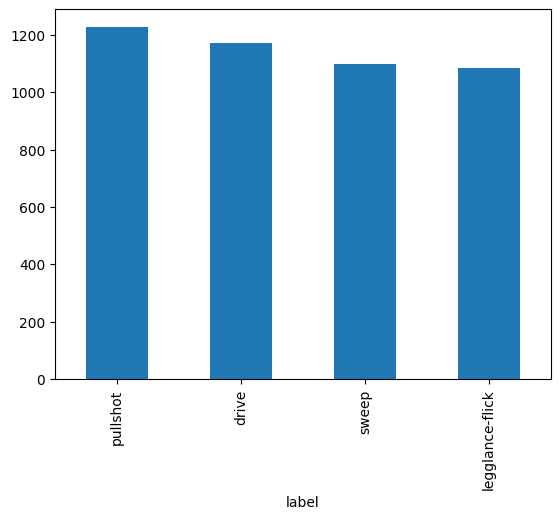

In [14]:
df['label'].value_counts().plot(kind='bar')

In [8]:
X = df # Contains all columns.
y = df[['label']] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=0.30,
                                                          random_state=40)

    # Split the temp dataframe into val and test dataframes.

df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=0.5,
                                                      random_state=40)

In [9]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

# EfficientNet

In [13]:
train_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)
test_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)

eff_model = EfficientNetV2M(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
eff_model.trainable = False
eff_output = eff_model.output 

x = Flatten()(eff_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
eff_final_model = Model(eff_model.input, output)

214201816/214201816 [==============================] - 8s 0us/step


In [5]:
BATCH_SIZE = 32
IMG_SHAPE = (256, 256, 3)
num_classes = 5
IMG_SHAPE_2 = (224, 224, 3)
# We create a Learning Rate Reducer that will reduce the learning rate by half if the validation loss does not decrease in 4 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose = 1)

# We stop the model training if we see no improvement (reduction in validation loss) for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

In [14]:
LR = 0.0003
eff_final_model.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])
train_generator = train_efficientnet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_efficientnet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_efficientnet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 3210 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.


In [21]:
history_efficientnet = eff_final_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/10


2024-01-24 14:18:20.383065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


101/101 [==============================] - 98s 725ms/step - loss: 1.4117 - accuracy: 0.4153 - val_loss: 0.9708 - val_accuracy: 0.5349 - lr: 3.0000e-04
Epoch 2/10
101/101 [==============================] - 33s 330ms/step - loss: 0.9667 - accuracy: 0.6056 - val_loss: 0.5996 - val_accuracy: 0.7849 - lr: 3.0000e-04
Epoch 3/10
101/101 [==============================] - 34s 333ms/step - loss: 0.6671 - accuracy: 0.7346 - val_loss: 0.3752 - val_accuracy: 0.8605 - lr: 3.0000e-04
Epoch 4/10
101/101 [==============================] - 34s 340ms/step - loss: 0.5158 - accuracy: 0.8037 - val_loss: 0.2930 - val_accuracy: 0.8953 - lr: 3.0000e-04
Epoch 5/10
101/101 [==============================] - 34s 338ms/step - loss: 0.3512 - accuracy: 0.8685 - val_loss: 0.2072 - val_accuracy: 0.9288 - lr: 3.0000e-04
Epoch 6/10
101/101 [==============================] - 34s 336ms/step - loss: 0.3306 - accuracy: 0.8819 - val_loss: 0.1948 - val_accuracy: 0.9273 - lr: 3.0000e-04
Epoch 7/10
101/101 [===================

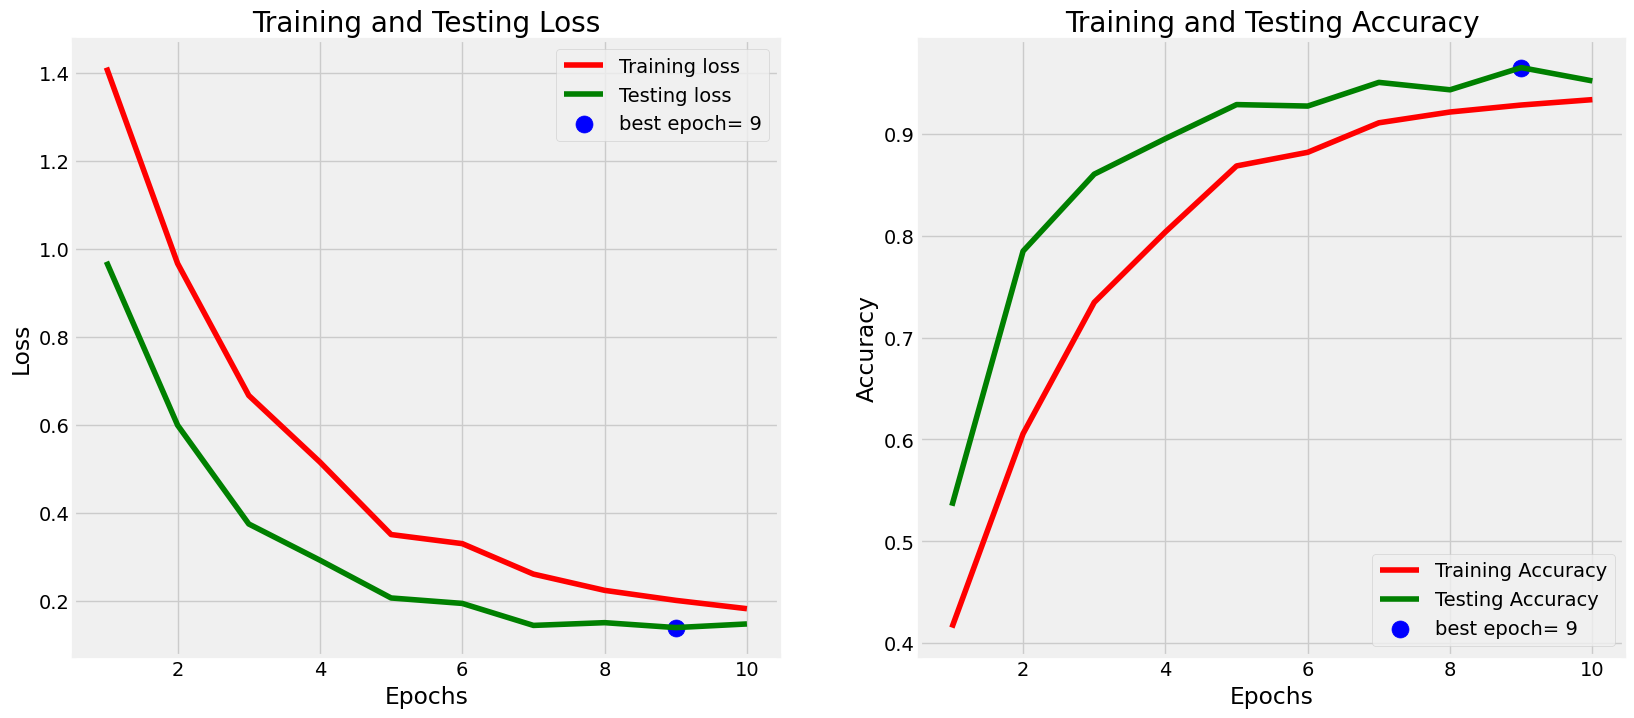

In [22]:
plot_training(history_efficientnet)

# InceptionNet

In [14]:
train_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing, horizontal_flip=True, vertical_flip=True)
val_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)
test_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)

In [15]:
inception_model =  InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inception_model_output = inception_model.output

x = Flatten()(inception_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.15)(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
inception_output = Dense(num_classes, activation='softmax')(x)
inception_final = Model(inception_model.input, inception_output)

87910968/87910968 [==============================] - 4s 0us/step


In [16]:
LR = 0.0003
inception_final.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [17]:
history_inception = inception_final.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
101/101 [==============================] - 54s 415ms/step - loss: 1.3324 - accuracy: 0.3782 - val_loss: 1.8710 - val_accuracy: 0.3939 - lr: 3.0000e-04
Epoch 2/10
101/101 [==============================] - 27s 264ms/step - loss: 0.8101 - accuracy: 0.6763 - val_loss: 1.4590 - val_accuracy: 0.6642 - lr: 3.0000e-04
Epoch 3/10
101/101 [==============================] - 27s 263ms/step - loss: 0.3806 - accuracy: 0.8804 - val_loss: 1.4683 - val_accuracy: 0.7297 - lr: 3.0000e-04
Epoch 4/10
101/101 [==============================] - 27s 261ms/step - loss: 0.2131 - accuracy: 0.9393 - val_loss: 0.6085 - val_accuracy: 0.8067 - lr: 3.0000e-04
Epoch 5/10
101/101 [==============================] - 27s 265ms/step - loss: 0.1309 - accuracy: 0.9614 - val_loss: 0.7515 - val_accuracy: 0.8169 - lr: 3.0000e-04
Epoch 6/10
101/101 [==============================] - 26s 257ms/step - loss: 0.1761 - accuracy: 0.9520 - val_loss: 0.4284 - val_accuracy: 0.8488 - lr: 3.0000e-04
Epoch 7/10
101/101 [========

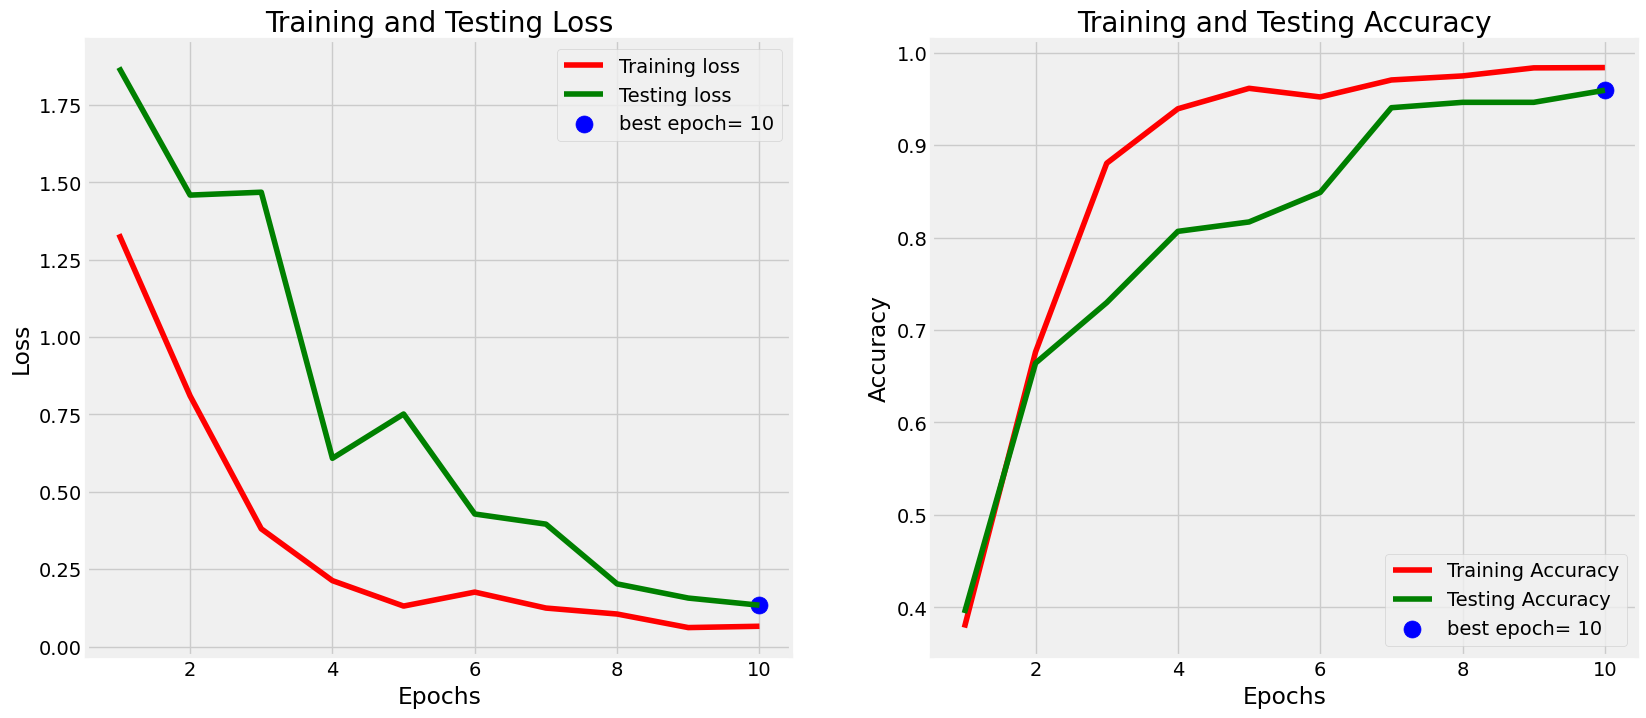

In [18]:
plot_training(history_inception)

# DenseNet

In [23]:
train_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing)
test_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing)

In [24]:
train_generator = train_densenet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_densenet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_densenet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 3210 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.
Found 688 validated image filenames belonging to 4 classes.


In [19]:
densenet_model = DenseNet121(input_shape=IMG_SHAPE_2, include_top=False, weights='imagenet')
densenet_model_output = densenet_model.output

x = Flatten()(densenet_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
densenet_out = Dense(num_classes, activation='softmax')(x)
densenet_m = Model(densenet_model.input, densenet_out)

29084464/29084464 [==============================] - 2s 0us/step


In [20]:
LR = 0.0003
densenet_m.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

In [25]:
history_densenet = densenet_m.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
101/101 [==============================] - 37s 326ms/step - loss: 1.3355 - accuracy: 0.4623 - val_loss: 0.9921 - val_accuracy: 0.6817 - lr: 3.0000e-04
Epoch 2/10
101/101 [==============================] - 28s 279ms/step - loss: 0.4247 - accuracy: 0.8498 - val_loss: 0.4671 - val_accuracy: 0.8576 - lr: 3.0000e-04
Epoch 3/10
101/101 [==============================] - 28s 273ms/step - loss: 0.1886 - accuracy: 0.9405 - val_loss: 3.1802 - val_accuracy: 0.6265 - lr: 3.0000e-04
Epoch 4/10
101/101 [==============================] - 27s 270ms/step - loss: 0.1948 - accuracy: 0.9402 - val_loss: 0.2198 - val_accuracy: 0.9390 - lr: 3.0000e-04
Epoch 5/10
101/101 [==============================] - 28s 277ms/step - loss: 0.1114 - accuracy: 0.9688 - val_loss: 1.3314 - val_accuracy: 0.8532 - lr: 3.0000e-04
Epoch 6/10
101/101 [==============================] - 26s 261ms/step - loss: 0.1332 - accuracy: 0.9604 - val_loss: 1.6095 - val_accuracy: 0.6570 - lr: 3.0000e-04
Epoch 7/10
101/101 [========

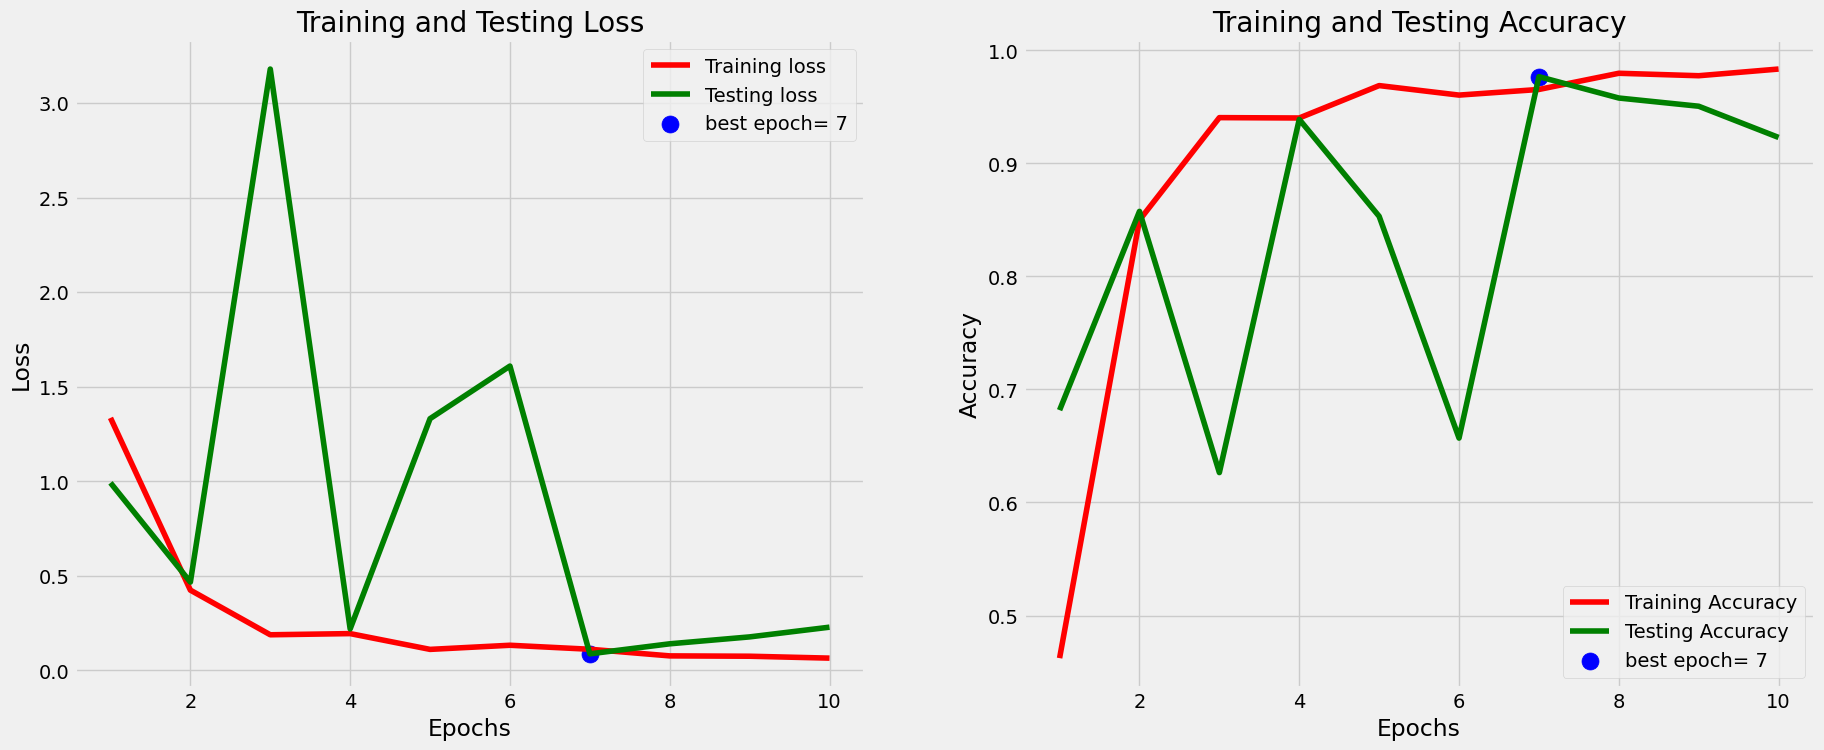

In [26]:
plot_training(history_densenet)

# ResNet50

In [6]:
model_ResNet =tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=IMG_SHAPE_2,
    weights='imagenet'
)
model_ResNet.trainable = False

#adding input and output layers
input_layer = tf.keras.layers.Input(shape=(224,224,3))
x = model_ResNet(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(num_classes,activation='softmax')(x)

model_ResNet = tf.keras.Model(inputs=[input_layer],outputs=[output])



94765736/94765736 [==============================] - 228s 2us/step


In [28]:
model_ResNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history_res = model_ResNet.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
101/101 [==============================] - 31s 278ms/step - loss: 9.0755 - accuracy: 0.5274 - val_loss: 0.6297 - val_accuracy: 0.7762 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 26s 255ms/step - loss: 0.5775 - accuracy: 0.7804 - val_loss: 0.4775 - val_accuracy: 0.8270 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - 26s 260ms/step - loss: 0.4461 - accuracy: 0.8262 - val_loss: 0.3949 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 4/10
101/101 [==============================] - 26s 258ms/step - loss: 0.3711 - accuracy: 0.8589 - val_loss: 0.3162 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 5/10
101/101 [==============================] - 26s 257ms/step - loss: 0.3135 - accuracy: 0.8841 - val_loss: 0.4699 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 6/10
101/101 [==============================] - 26s 261ms/step - loss: 0.2653 - accuracy: 0.9028 - val_loss: 0.2833 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 7/10
101/101 [==============================] 

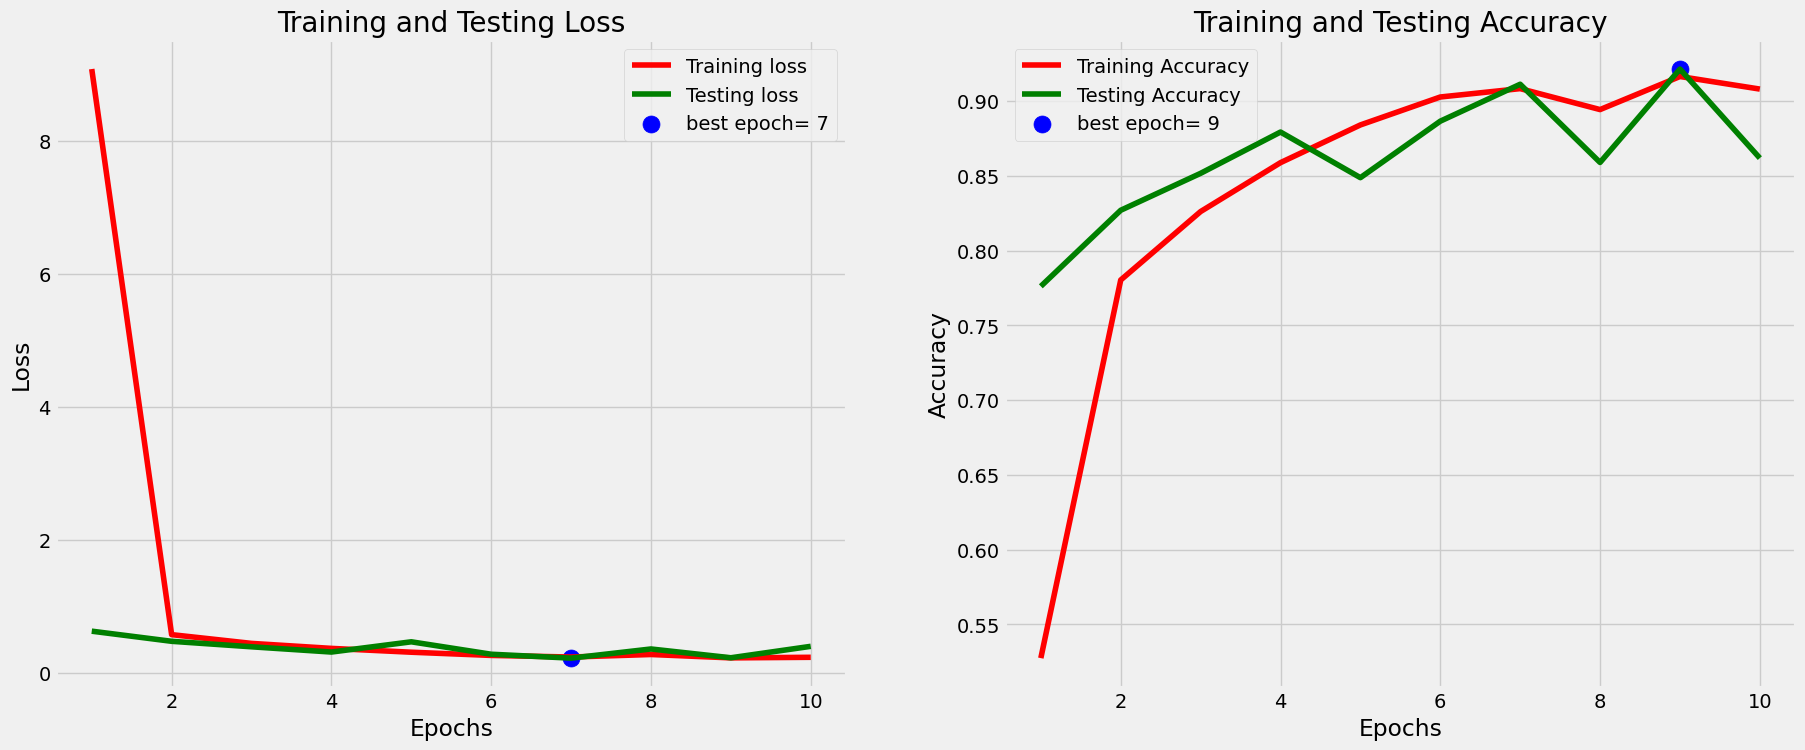

In [31]:
plot_training(history_res)